In [1]:
%matplotlib inline

In [2]:
from __future__ import division, print_function, absolute_import
import autograd.numpy as np
import numdifftools as nd
import matplotlib.pyplot as plt

### Read in data

In [3]:
X = np.genfromtxt('../data/NICER_MAXIJ1535_1050360106.dat').T
X.shape

(2, 358912)

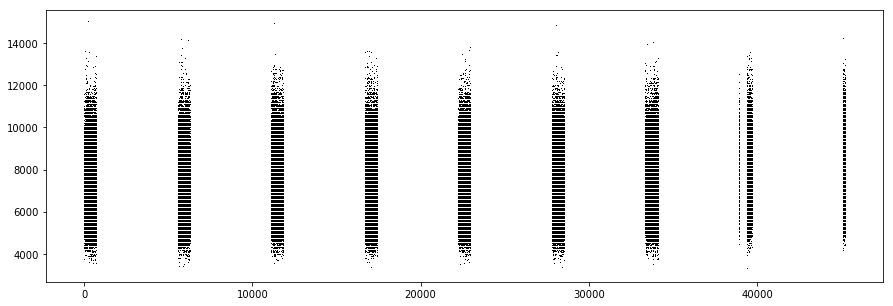

In [4]:
x = X[0].flatten()
y = X[1].flatten()
plt.figure(figsize=(15,5))
plt.plot(x,y,'k,')

### Break up into chunks & plot FFT of each chunk

In [5]:
dt = x[1:] - x[:-1]
gaps = np.array(np.where(dt > 3000)[0]) + 1
gaps = np.append(np.append(0, gaps), -1)
gaps = gaps[:-2] # last 2 segments are partial so skip them for now

0.015625 719.0 718.984375
5558.01562 6279.0 720.9843799999999
11116.0156 11839.0 722.9843999999994
16674.0156 17434.0 759.9844000000012
22232.0156 22959.0 726.9844000000012
27790.0156 28519.0 728.9844000000012
33349.0156 34119.0 769.9844000000012


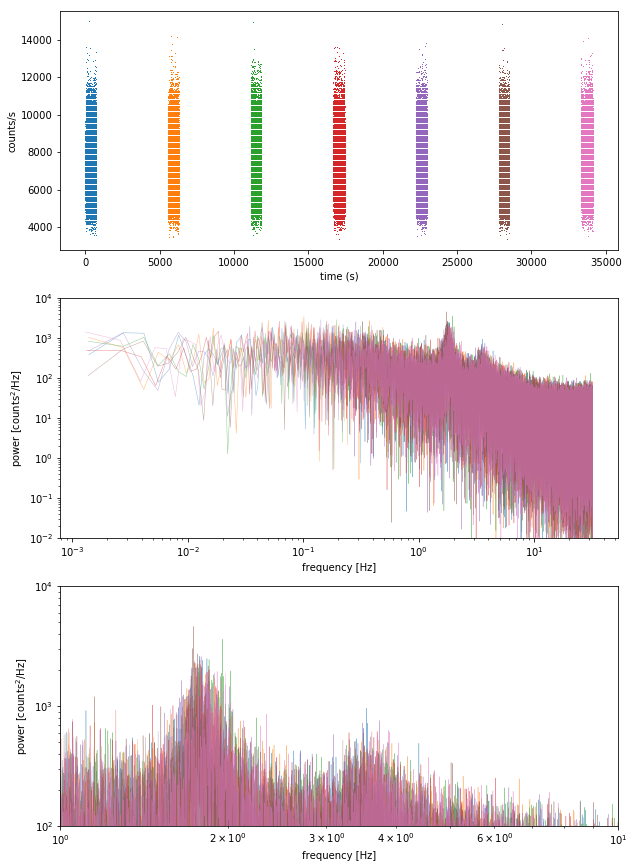

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(10,15))
for i in range(len(gaps)-1):
    xx = x[gaps[i]:gaps[i+1]]
    print(xx.min(), xx.max(), xx.max()-xx.min())
    yy = y[gaps[i]:gaps[i+1]]
    N = len(xx)
    axes[0].plot(xx, yy, ',')
    f = np.fft.rfftfreq(len(xx), xx[1] - xx[0])
    fft = np.fft.rfft(yy)
    fft *= np.conj(fft)
    power_fft = fft.real / N**2
    axes[1].loglog(f, power_fft, "-", lw=0.5, alpha = 0.5)
    axes[2].loglog(f, power_fft, "-", lw=0.5, alpha = 0.5)
axes[0].set_xlabel('time (s)')
axes[0].set_ylabel('counts/s')
axes[1].set_ylabel("power [$\mathrm{counts}^2/\mathrm{Hz}$]")
axes[1].set_xlabel("frequency [Hz]")
axes[1].set_ylim(1e-2,1e4)
axes[2].set_ylabel("power [$\mathrm{counts}^2/\mathrm{Hz}$]")
axes[2].set_xlabel("frequency [Hz]")
axes[2].set_ylim(1e2,1e4)
axes[2].set_xlim(1,10);

### Define routines for GP fitting


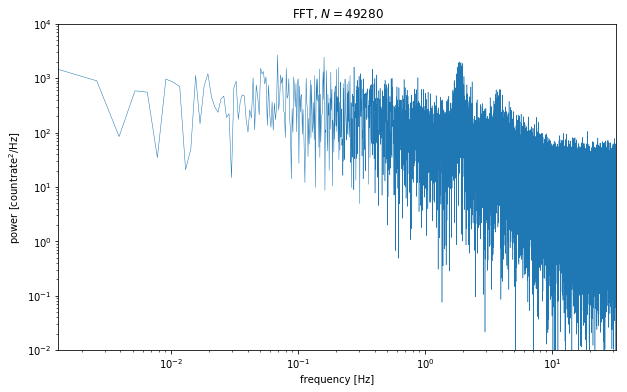

In [7]:
plt.figure(figsize=(10,6))
plt.loglog(f, power_fft, "C0-",lw=0.5)
plt.xlim(f.min(), f.max())
plt.ylabel("power [$\mathrm{countrate}^2/\mathrm{Hz}$]")
plt.xlabel("frequency [Hz]")
plt.title("FFT, $N = {0}$".format(N))
plt.ylim(1e-2,1e4);

In [8]:
from scipy.ndimage import gaussian_filter
from astropy.stats import LombScargle

def lomb_scargle_estimator(x, y, yerr=None,
                           min_period=None, max_period=None,
                           filter_period=None,
                           max_peaks=2,
                           **kwargs):
    """
    Estimate period of a time series using the periodogram

    Args:
        x (ndarray[N]): The times of the observations
        y (ndarray[N]): The observations at times ``x``
        yerr (Optional[ndarray[N]]): The uncertainties on ``y``
        min_period (Optional[float]): The minimum period to consider
        max_period (Optional[float]): The maximum period to consider
        filter_period (Optional[float]): If given, use a high-pass filter to
            down-weight period longer than this
        max_peaks (Optional[int]): The maximum number of peaks to return
            (default: 2)

    Returns:
        A dictionary with the computed ``periodogram`` and the parameters for
        up to ``max_peaks`` peaks in the periodogram.

    """
    if min_period is not None:
        kwargs["maximum_frequency"] = 1.0 / min_period
    if max_period is not None:
        kwargs["minimum_frequency"] = 1.0 / max_period

    # Estimate the power spectrum
    model = LombScargle(x, y, yerr)
    freq, power = model.autopower(method="fast", normalization="psd", **kwargs)
    power /= len(x)
    power_est = np.array(power)

    # Filter long periods
    if filter_period is not None:
        freq0 = 1.0 / filter_period
        filt = 1.0 / np.sqrt(1 + (freq0 / freq) ** (2*3))
        power *= filt

    # Find and fit peaks
    peak_inds = (power[1:-1] > power[:-2]) & (power[1:-1] > power[2:])
    peak_inds = np.arange(1, len(power)-1)[peak_inds]
    peak_inds = peak_inds[np.argsort(power[peak_inds])][::-1]
    peaks = []
    for i in peak_inds[:max_peaks]:
        A = np.vander(freq[i-1:i+2], 3)
        w = np.linalg.solve(A, np.log(power[i-1:i+2]))
        sigma2 = -0.5 / w[0]
        freq0 = w[1] * sigma2
        peaks.append(dict(
            log_power=w[2] + 0.5*freq0**2 / sigma2,
            period=1.0 / freq0,
            period_uncert=np.sqrt(sigma2 / freq0**4),
        ))

    return dict(
        periodogram=(freq, power_est),
        peaks=peaks,
    )

In [9]:
import celerite
from celerite import terms

class MixtureOfSHOsTerm(terms.SHOTerm):
    parameter_names = ("log_a", "log_dQ1", "mix_par", "log_dQ2", "log_P")

    def get_real_coefficients(self, params):
        return np.empty(0), np.empty(0)

    def get_complex_coefficients(self, params):
        log_a, log_dQ1, mix_par, log_dQ2, log_period = params

        log_Q1 = np.log(1./np.sqrt(2) + np.exp(log_dQ1))
        log_Q2 = np.log(1./np.sqrt(2) + np.exp(log_dQ1) + np.exp(log_dQ2))
        
        Q = np.exp(log_Q2) + np.exp(log_Q1)
        log_Q1 = np.log(Q)
        P = np.exp(log_period)
        log_omega1 = np.log(4*np.pi*Q) - np.log(P) - 0.5*np.log(4.0*Q*Q-1.0)
        log_S1 = log_a - log_omega1 - log_Q1

        mix = -np.log(1.0 + np.exp(-mix_par))
        Q = np.exp(log_Q2)
        P = 0.5*np.exp(log_period)
        log_omega2 = np.log(4*np.pi*Q) - np.log(P) - 0.5*np.log(4.0*Q*Q-1.0)
        log_S2 = mix + log_a - log_omega2 - log_Q2

        c1 = super(MixtureOfSHOsTerm, self).get_complex_coefficients([
            log_S1, log_Q1, log_omega1,
        ])

        c2 = super(MixtureOfSHOsTerm, self).get_complex_coefficients([
            log_S2, log_Q2, log_omega2,
        ])

        return [np.array([a, b]) for a, b in zip(c1, c2)]

    def log_prior(self):
        lp = super(MixtureOfSHOsTerm, self).log_prior()
        if not np.isfinite(lp):
            return -np.inf
        mix = 1.0 / (1.0 + np.exp(-self.mix_par))
        return lp + np.log(mix) + np.log(1.0 - mix)

def get_basic_kernel(t, y, yerr):
    # Low-Q SHO term to represent correlated noise
    kernel = terms.SHOTerm(
        log_S0=np.log(np.var(y)),
        log_Q=-np.log(4.0),
        log_omega0=np.log(2*np.pi/10.),
        bounds=dict(
            log_S0=(-20.0, 20.0),
            log_omega0=(np.log(2*np.pi/80.0), np.log(2*np.pi/2.0)),
        ),
    )
    kernel.freeze_parameter('log_Q')
    # Jitter term to represent white noise
    kernel += terms.JitterTerm(log_sigma=np.log(yerr),
                               bounds=[(-20.0, 10.0)])
    return kernel

def get_simple_gp(t, y, yerr):
    # Correlated noise and jitter only
    gp = celerite.GP(kernel=get_basic_kernel(t, y, yerr), mean=1.)
    gp.compute(t)
    return gp

def get_rotation_gp(t, y, yerr, period, min_period, max_period):
    # Rotation, correlated noise and jitter
    kernel = get_basic_kernel(t, y, yerr)
    kernel += MixtureOfSHOsTerm(
        log_a=np.log(np.var(y)),
        log_dQ1=np.log(7.0-1./np.sqrt(2)),
        mix_par=-1.0,
        log_dQ2=0.0,
        log_P=np.log(period),
        bounds=dict(
            log_a=(-20.0, 20.0),
            log_dQ1=(-5, 10.0),
            mix_par=(-10.0, 10.0),
            log_dQ2=(-5, 10.0),
            log_P=(np.log(min_period), np.log(max_period)),
        )
    )
    gp = celerite.GP(kernel=kernel, mean=np.mean(y))
    gp.compute(t)
    return gp


In [10]:
import scipy.optimize as op
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]
    

In [11]:
def fit_lc(x, y, e, min_period = 0.05, max_period = 60, prefix = 'NICER_MAXIJ1535'):
    fig, axes = plt.subplots(3,1,figsize=(15,15))
    ax1, ax2, ax3 = axes
    ax1.plot(x,y,'k.',ms=4,alpha=0.5, label = 'data')
    ax1.set_xlim(x.min(), x.max())
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('count rate')

    ls = lomb_scargle_estimator(x, y, min_period = min_period, 
                                max_period = max_period, filter_period = max_period/3)
    freqs, lsp = ls['periodogram']
    p0 = ls['peaks'][0]['period']
    ax2.axvline(1./p0, color='C0')
    ax2.loglog(freqs, lsp, 'k-', lw=0.5, label = 'LS')
    yerr = np.median(e)

    gp = get_rotation_gp(x, y, yerr, p0, min_period, max_period)
    #gp.freeze_parameter('kernel:terms[1]:log_sigma')
    celp = gp.kernel.get_psd(2*np.pi*freqs) / 2 / np.pi
    celp1 = gp.kernel.terms[0].get_psd(2*np.pi*freqs) / 2 / np.pi
    celp2 = gp.kernel.terms[2].get_psd(2*np.pi*freqs) / 2 / np.pi
    ax2.plot(freqs, celp, 'C0-', label = 'cel in')
    ax2.plot(freqs, celp1, 'C0:')
    ax2.plot(freqs, celp2, 'C0--')

    imin = 3
    nsel = 1000
    xmin = x[imin]
    xmax = x[imin+nsel]
    ls = (x>=xmin) * (x<xmax)
    xs = x[ls]
    ys = y[ls]
    es = e[ls]
    
    ax3.plot(xs,ys,'k.',ms=4,alpha=0.5, label = 'data')
    gp.compute(xs,es)
    mu, var = gp.predict(ys, t=xs, return_var=True)
    std = np.sqrt(var)
    ax3.plot(xs, mu, 'C0-', label = 'cel in')
    ax3.fill_between(xs, mu + 2 * std, mu - 2 * std, color = 'C0', lw = 0, alpha = 0.3)

    gp.compute(x,e)
    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    # try with default params
    soln = op.minimize(neg_log_like, initial_params,jac=grad_neg_log_like,
                           method="L-BFGS-B", bounds=bounds, args=(y, gp))
    
    fit_params = soln['x']
    fit_nll = soln['fun']
    # try doubling input period
#    initial_params[-1] += np.log(2)
#    soln = op.minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
#                           method="L-BFGS-B", bounds=bounds, args=(y, gp))
#    if soln['fun'] <= fit_nll:
#        fit_params = soln['x']
#        fit_nll = soln['fun']
    # try halving input period
#    initial_params[-1] -= 2*np.log(2)
#    soln = op.minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
#                           method="L-BFGS-B", bounds=bounds, args=(y, gp))
#    if soln['fun'] <= fit_nll:
#        fit_params = soln['x']
#        fit_nll = soln['fun']
    # evaluate Hessian using numdifftools
#    def nll(params):
#        gp.set_parameter_vector(params)
#        try:
#            return -gp.log_likelihood(y)
#        except:
#            return 1e25
#    Hfun = nd.Hessian(nll)
#    Hmat = Hfun(fit_params)
#    try:
#        Hess_inv = np.linalg.inv(Hmat)
#        fit_errs = np.sqrt(np.diag(Hess_inv))
#        samps = np.random.multivariate_normal(fit_params, Hess_inv, 10)
#        for i in range(10):
#            gp.set_parameter_vector(samps[i])
#            try:
#                celp = gp.kernel.get_psd(2*np.pi*freqs) / 2 / np.pi
#            except:
#                continue
#            wn = np.exp(gp.get_parameter_vector()[2]) / (len(y)/2)
#            celp += wn
#            plt.plot(freqs, celp, 'C1-', alpha = 0.2)
#    except:
#        fit_errs = np.zeros_like(fit_params) + np.nan

    gp.set_parameter_vector(fit_params)
    p1 = np.exp(fit_params[-1])
#    print(gp.get_parameter_dict())
    celp = gp.kernel.get_psd(2*np.pi*freqs) / 2 / np.pi
    celp1 = gp.kernel.terms[0].get_psd(2*np.pi*freqs) / 2 / np.pi
    celp2 = gp.kernel.terms[2].get_psd(2*np.pi*freqs) / 2 / np.pi
    wn = np.exp(gp.get_parameter_vector()[2]) / (len(y)/2)
    #celp += wn
    ax2.plot(freqs, celp, 'C1-', label = 'cel out')
    ax2.plot(freqs, celp1, 'C1:')
    ax2.plot(freqs, celp2, 'C1--')
    ax2.axvline(1./p1, color='C1')
    #ax2.axhline(wn, color = 'C1', ls = 'dashdot')
    ax2.set_xlim(freqs.min(), freqs.max())
    ax2.legend(loc=0)
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel(r'PSD (counts)$^2$/Hz')

    gp.compute(xs,es)
    mu, var = gp.predict(ys, t=xs, return_var=True)
    std = np.sqrt(var)
    ax3.plot(xs, mu, 'C1-', label = 'cel out')
    ax3.fill_between(xs, mu + 2 * std, mu - 2 * std, color = 'C1', lw = 0, alpha = 0.3)
    ax3.set_xlim(xs.min(),xs.max())
    ax3.set_ylim(3000,15000)
    ax3.legend(loc=0)
    ax3.set_xlabel('time (s)')
    ax3.set_ylabel('count rate')
    plt.savefig('../plots/{:s}.png'.format(prefix))
    return fit_params, gp

### Fit GP chunk by chunk

Fitting chunk 1


/Users/aigrain/anaconda/lib/python2.7/site-packages/autograd/numpy/numpy_extra.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return A[idx]


0.5324980827295869
Fitting chunk 2
0.5358548640549002
Fitting chunk 3
0.5137367670934511
Fitting chunk 4
0.5053965625758436
Fitting chunk 5
0.550055650977449
Fitting chunk 6
0.5515504763576153
Fitting chunk 7
0.5190639718217929


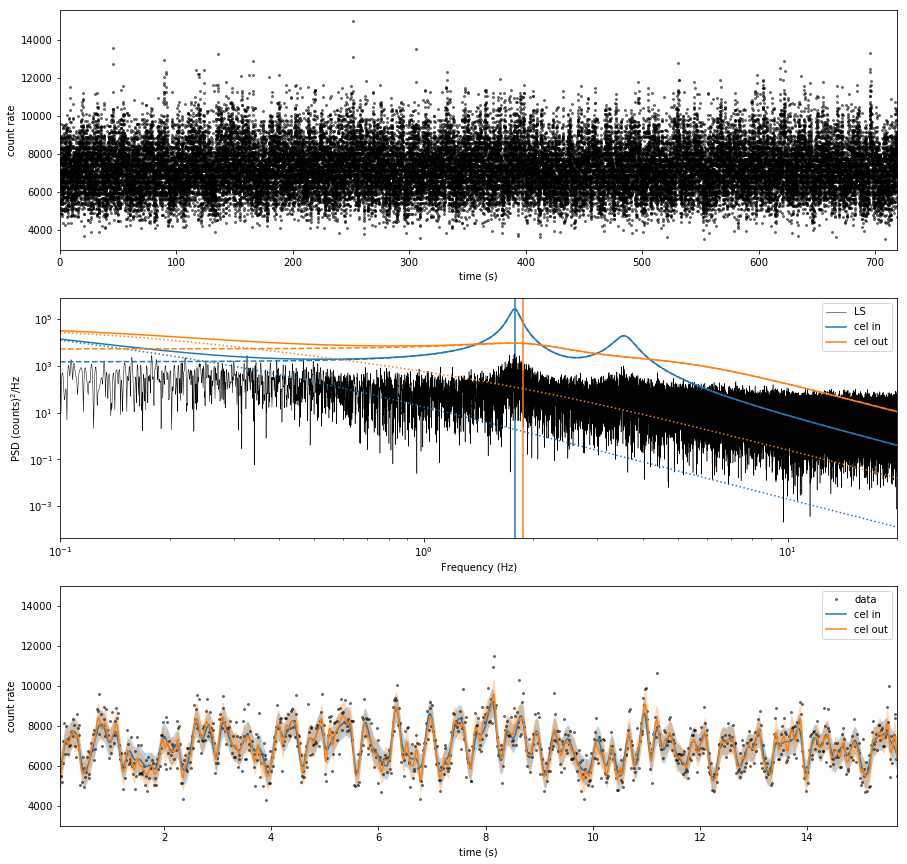

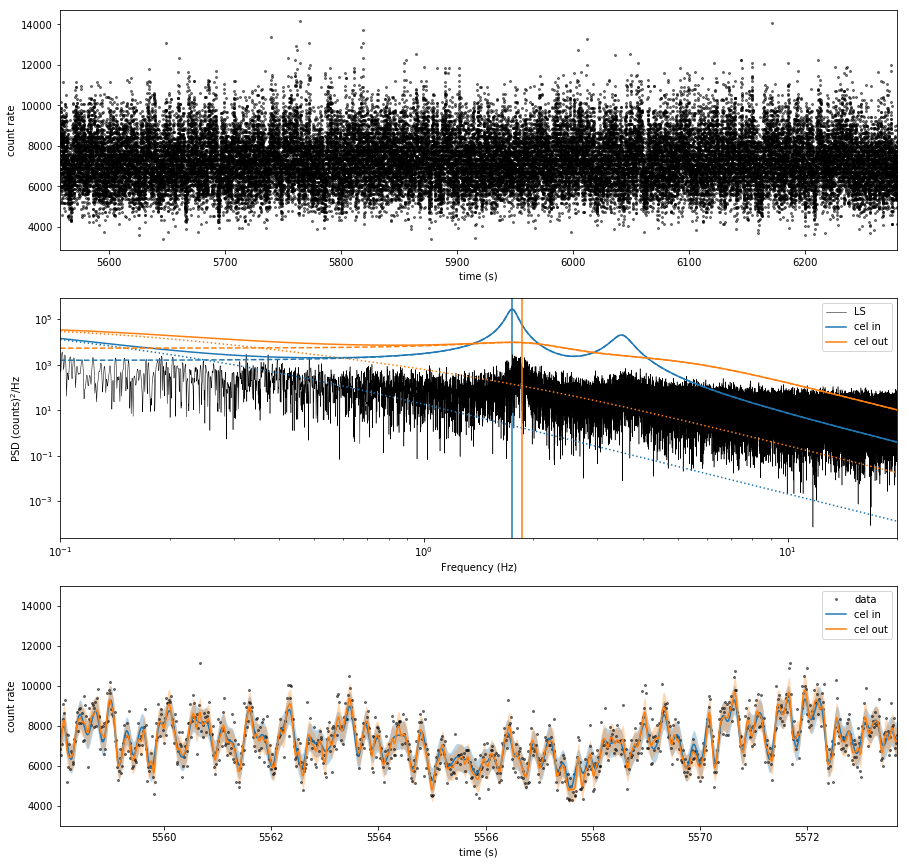

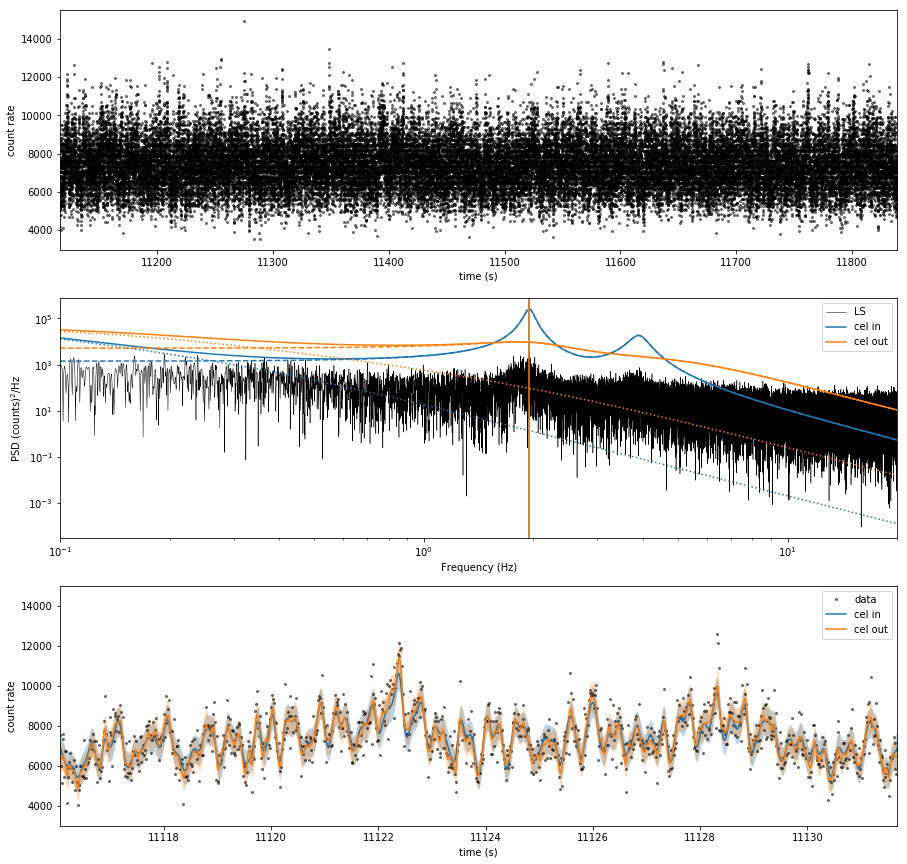

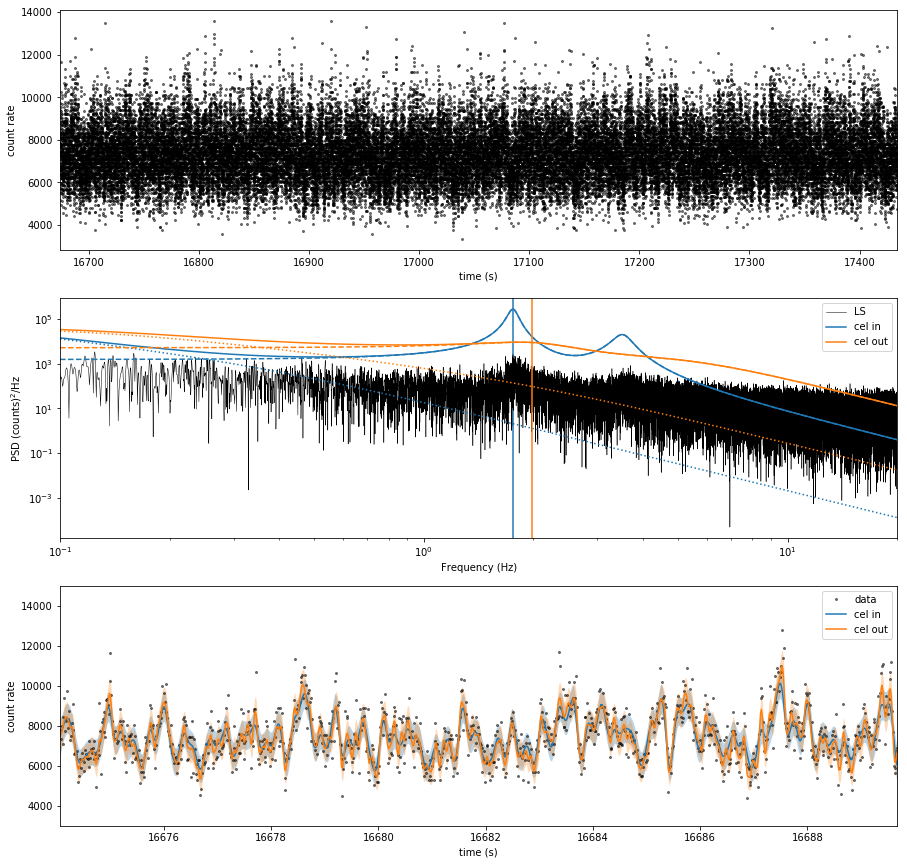

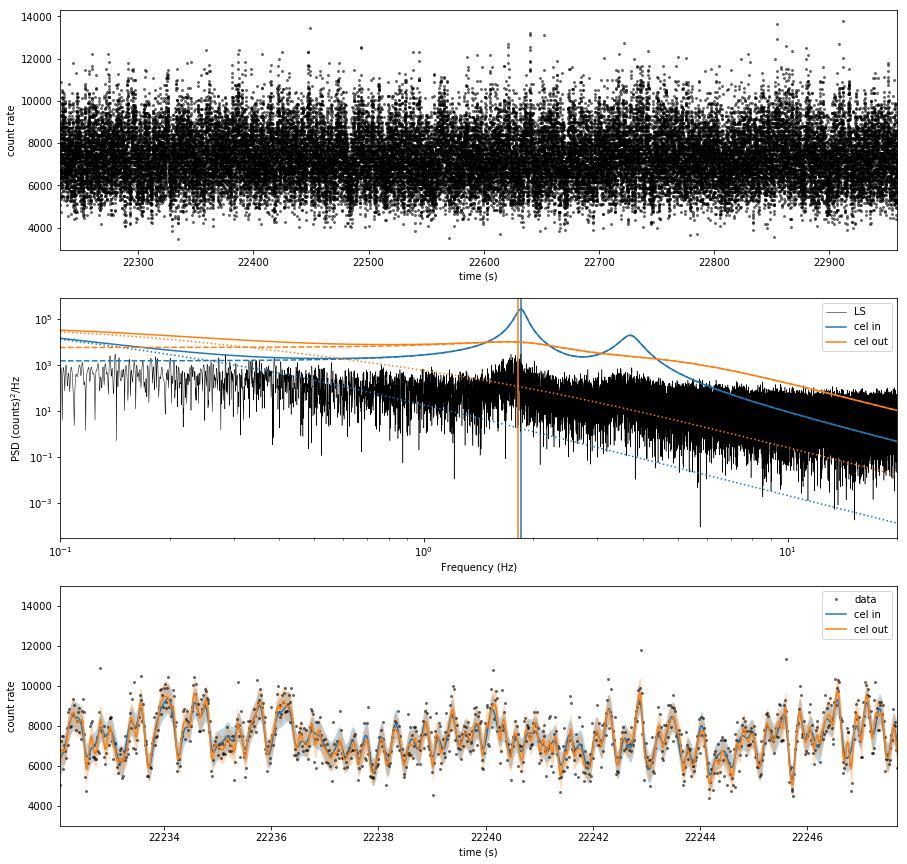

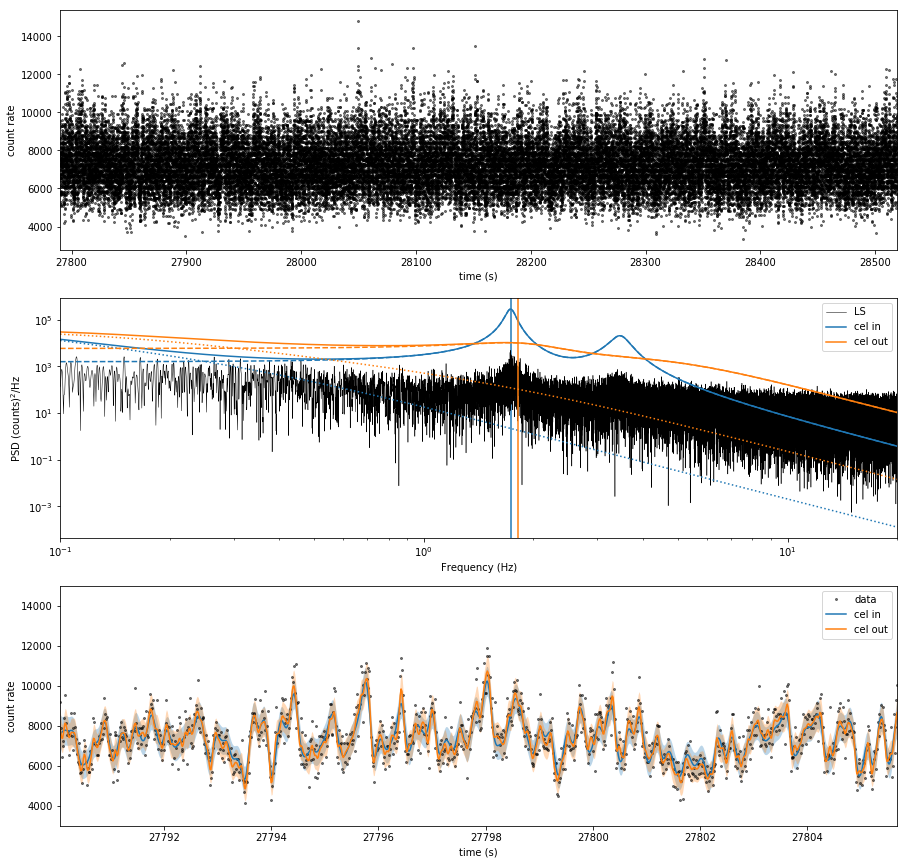

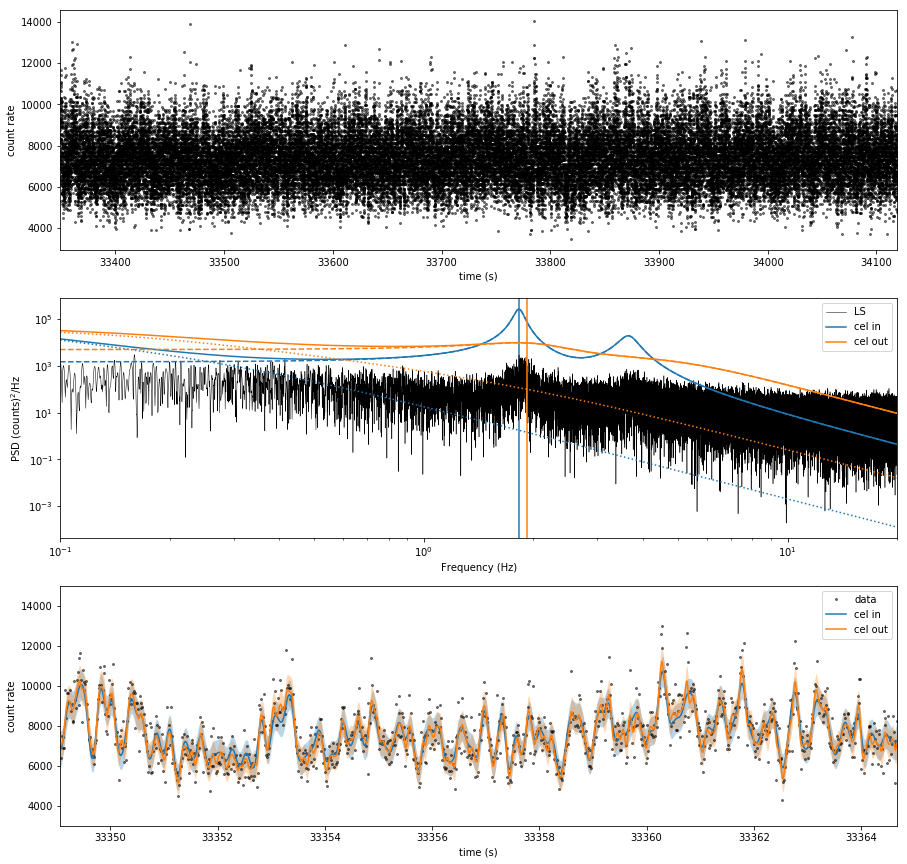

In [12]:
for i in range(len(gaps)-1):
    print('Fitting chunk {}'.format(i+1))
    xx = x[gaps[i]:gaps[i+1]]
    yy = y[gaps[i]:gaps[i+1]]
    ee = np.sqrt(yy*64)
    par, gp = fit_lc(xx, yy, ee, min_period = 0.05, max_period = 10, prefix = 'NICER_MAXIJ1535_{:d}'.format(i+1))
    print(np.exp(par[-1]))